# Test technique : Détection d'anomalies dans des transactions financières

### Compréhension des données :

Dans cette première étape, nous importons le fichier CSV contenant les transactions financières à l'aide de la bibliothèque pandas, puis nous explorons les données.

In [388]:
import pandas as pd

df = pd.read_csv("D:/Documents/FRANCE/TRAINNING/Stage/Test technique KLESIA/transactions_avec_anomalies.csv", delimiter = ',')
df.head(10)

,id_transaction,montant,date,lieu
0,1,174.835708,2025-01-01 00:00:00,Marseille
1,2,143.086785,2025-01-01 00:01:00,Versailles
2,3,182.384427,2025-01-01 00:02:00,Lyon
3,4,226.151493,2025-01-01 00:03:00,Versailles
4,5,138.292331,2025-01-01 00:04:00,Versailles
5,6,138.293152,2025-01-01 00:05:00,Paris
6,7,228.960641,2025-01-01 00:06:00,Paris
7,8,188.371736,2025-01-01 00:07:00,Paris
8,9,126.526281,2025-01-01 00:08:00,Marseille
9,10,177.128002,2025-01-01 00:09:00,Paris


In [389]:
df['id_transaction'].duplicated().any()

False

Ce réultat indique qu'il n'y a pas de doublons dans la colonne `id_transaction`. Ce qui signifie que chaque transaction est unique.

In [391]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_transaction  10000 non-null  int64  
 1   montant         10000 non-null  float64
 2   date            10000 non-null  object 
 3   lieu            10000 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 312.6+ KB


Les résultats de `df.info()` indiquent que toutes les colonnes comptent 10000 valeurs non nulles, confirmant qu'il n'y a pas de valeurs manquantes.  
On remarque également que la colonne `date` est de type `object`, ce qui suggère de la convertir en format date pour faciliter son traitement.

In [393]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_transaction  10000 non-null  int64         
 1   montant         10000 non-null  float64       
 2   date            10000 non-null  datetime64[ns]
 3   lieu            10000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 312.6+ KB


la colonne `date` a été correctement convertie en type `datetime64[ns]`

In [395]:
df['montant'].describe()

count    10000.000000
mean       161.033886
std        266.896080
min        -46.120013
25%        116.487927
50%        150.018376
75%        183.819733
max       9805.280777
Name: montant, dtype: float64

Les statistiques descriptives de la colonne `montant` révèlent que :  
- Le minimum de -46.12 indique la présence de montants négatifs, ce qui peut être anormal.  
- Le maximum de 9805.28 est très élevé comparé au troisième quartile (183.82), suggérant l'existence de valeurs aberrantes.


In [397]:
negative_count = (df['montant'] < 0).sum()
print("Nombre de valeurs négatives :", negative_count)

Nombre de valeurs négatives : 12


Un montant négatif peut être normal dans certains cas (par exemple, pour désigner des dettes ou des dépenses). Toutefois, puisque le nombre de montants négatifs (12) est négligeable par rapport au nombre total des transactions, il est probable que ces valeurs soient des anomalies.

In [399]:
df['lieu'].unique()

array(['Marseille', 'Versailles', 'Lyon', 'Paris'], dtype=object)

Les noms de villes présents (Marseille, Versailles, Lyon, Paris) sont correctement orthographiés et aucune variation n'a été constatée.

### Caractéristiques du jeu de données :
**id_transaction :** Cette variable est un identifiant numérique unique pour chaque transaction, garantissant l'unicité des enregistrements. Elle permet de référencer chaque opération de manière précise et sert de clé primaire dans le dataset.

**montant :** Le montant, sous forme de nombre à virgule flottante, représente la valeur financière de chaque transaction. Ses caractéristiques incluent une plage de valeurs qui peut révéler des anomalies (transactions exceptionnellement élevées ou négatives) et sont essentielles pour toute analyse financière.

**date :** Cette variable contient la date et l'heure de la transaction sous forme de chaîne de caractères initialement, mais qui est convertie en format datetime pour permettre une analyse temporelle fine.

**lieu :** La variable lieu indique la localisation de la transaction, limitée aux villes de Paris, Versailles, Marseille et Lyon. Il s'agit d'une variable catégorielle dont le domaine restreint facilite la segmentation géographique.

### Types d'anomalies :

L'analyse exploratoire des données a mis en évidence deux anomalies principales concernant la variable montant. Tout d'abord, quelques transactions présentent des montants négatifs, ce qui est incohérent dans le cadre d'opérations financières classiques et peut résulter d'erreurs de saisie ou de cas particuliers nécessitant une vérification. Ensuite, en observant la distribution statistique, nous constatons que le troisième quantile est d'environ 183, tandis que le montant maximum atteint environ 9805. Cette disparité importante suggère la présence d'outliers ou d'opérations inhabituelles qui méritent une analyse plus fine pour déterminer s'il s'agit de transactions authentiques ou d'anomalies à corriger.

Aucune valeur manquante n'a été détectée, ce qui facilite l'analyse de ces anomalies.

### Prétraitement et normalisation

Avant d'appliquer les algorithmes de détection d'anomalies, nous avons effectué les étapes suivantes :

    Conversion de la colonne date : Les dates ont été converties en format datetime pour faciliter l'analyse temporelle.
    Vérification des valeurs manquantes : Aucune valeur manquante n'a été détectée dans le dataset.
    Nettoyage et homogénéisation de la variable lieu : La variable a été vérifiée et ajustée pour garantir l'uniformité des écritures.

Nous choisissons de normaliser les données car certains algorithmes de détection d'anomalies, tels que DBSCAN et One-Class SVM, sont sensibles aux distances et nécessitent des données sur une échelle homogène. Bien que l'algorithme Isolation Forest, utilisé dans notre cas, ne requière pas strictement de normalisation, il est judicieux de normaliser l'ensemble du dataset pour faciliter l'expérimentation et la comparaison entre différentes méthodes de détection d'anomalies.

In [404]:
from sklearn.preprocessing import MinMaxScaler

# Normaliser la variable 'montant'
scaler = MinMaxScaler()
df['montant_normalisé'] = scaler.fit_transform(df[['montant']])

# Afficher un apperçu
df.head()


,id_transaction,montant,date,lieu,montant_normalisé
0,1,174.835708,2025-01-01 00:00:00,Marseille,0.022429
1,2,143.086785,2025-01-01 00:01:00,Versailles,0.019206
2,3,182.384427,2025-01-01 00:02:00,Lyon,0.023195
3,4,226.151493,2025-01-01 00:03:00,Versailles,0.027638
4,5,138.292331,2025-01-01 00:04:00,Versailles,0.018719


In [405]:
df['montant_normalisé'].describe()

count    10000.000000
mean         0.021028
std          0.027092
min          0.000000
25%          0.016506
50%          0.019910
75%          0.023341
max          1.000000
Name: montant_normalisé, dtype: float64

Après l'application de la normalisation avec MinMaxScaler, nous constatons que les valeurs de la variable montant_normalisé se situent bien dans l'intervalle [0, 1], ce qui confirme que les données ont été correctement normalisées.

### Choix de l'algorithme :

Nous Choisissons d'utiliser l'algorithme Isolation Forest pour la détection d'anomalies. Voici ses avantages et inconvénients :

**Avantages :**

    Rapide et efficace sur de grands jeux de données.
    Robuste face aux outliers.
    Peu de paramètres à ajuster.
    Indépendant de la distribution des données.

**Inconvénients :**

    Sensible au choix des hyperparamètres.
    Moins performant dans la détection des anomalies proches de groupes denses.
    Peut être moins performant sur des jeux de données très bruyants.

### Implémentation technique :

In [409]:
from sklearn.ensemble import IsolationForest

# Choix de la variable
X = df[['montant_normalisé']]

# Création et entraînement du modèle Isolation Forest
clf = IsolationForest(contamination=0.01, random_state=42)
clf.fit(X)

# Prédiction des anomalies
df['anomalies'] = clf.predict(X)

# Affichage des anomalies détectées
anomalies = df[df['anomalies'] == -1]
anomalies.head(10)



,id_transaction,montant,date,lieu,montant_normalisé,anomalies
179,180,286.008458,2025-01-01 02:59:00,Versailles,0.033714,-1
209,210,342.636575,2025-01-01 03:29:00,Paris,0.039462,-1
262,263,-12.063367,2025-01-01 04:22:00,Versailles,0.003457,-1
478,479,303.944040,2025-01-01 07:58:00,Versailles,0.035534,-1
1000,1001,5285.460294,2025-01-01 16:40:00,Paris,0.541200,-1
1061,1062,7.572869,2025-01-01 17:41:00,Marseille,0.005450,-1
1079,1080,7710.749212,2025-01-01 17:59:00,Lyon,0.787387,-1
1089,1090,5238.441023,2025-01-01 18:09:00,Paris,0.536427,-1
1101,1102,5.187231,2025-01-01 18:21:00,Versailles,0.005208,-1
1342,1343,4043.628381,2025-01-01 22:22:00,Paris,0.415144,-1


**Explication du code et des paramètres :**

    X = df[['montant_normalisé']] : Sélection de la variable normalisée pour l'entraînement.
    IsolationForest(contamination=0.01, random_state=42) :
        contamination=0.01 indique que l'on suppose que 1 % des transactions sont des anomalies. Ce paramètre est essentiel pour ajuster la sensibilité du modèle.
        random_state=42 garantit la reproductibilité des résultats.
    clf.fit(X) : Entraîne le modèle sur les données.
    clf.predict(X) : Prédit les anomalies (-1 pour les points anormaux, 1 pour les points normaux).

**Choix du paramètre contamination**

Le paramètre contamination a été initialement fixé à 0.01 en se basant sur l'hypothèse que les anomalies représentent environ 1 % du dataset. Cependant, ce taux est ajustable. Nous allons tester plusieurs valeurs de contamination pour observer l’impact sur la détection des anomalies et comparer les résultats afin d’identifier le paramètre le plus adapté aux données.

In [410]:
anomalies.count()

id_transaction       96
montant              96
date                 96
lieu                 96
montant_normalisé    96
anomalies            96
dtype: int64

L'algorithme détécte 96 anomalies.

In [412]:
anomalies[anomalies['montant'] < 0].count()

id_transaction       12
montant              12
date                 12
lieu                 12
montant_normalisé    12
anomalies            12
dtype: int64

L'algorithme a identifié toutes les valeurs négatives du montant comme anomalies.

In [414]:
# Trier les anomalies par montant dans l'ordre croissant
anomalies_sorted = anomalies.sort_values(by='montant', ascending=True)
anomalies_sorted

,id_transaction,montant,date,lieu,montant_normalisé,anomalies
9770,9771,-46.120013,2025-01-07 18:50:00,Paris,0.000000,-1
8200,8201,-41.832777,2025-01-06 16:40:00,Versailles,0.000435,-1
7611,7612,-34.418265,2025-01-06 06:51:00,Marseille,0.001188,-1
7677,7678,-30.054255,2025-01-06 07:57:00,Marseille,0.001631,-1
8180,8181,-12.075691,2025-01-06 16:20:00,Paris,0.003456,-1
262,263,-12.063367,2025-01-01 04:22:00,Versailles,0.003457,-1
7140,7141,-11.050818,2025-01-05 23:00:00,Versailles,0.003560,-1
4779,4780,-8.835191,2025-01-04 07:39:00,Lyon,0.003785,-1
8024,8025,-6.925733,2025-01-06 13:44:00,Versailles,0.003979,-1
7305,7306,-2.232827,2025-01-06 01:45:00,Paris,0.004455,-1


Le but de cet affichage est simplement d'avoir un aperçu des anomalies détectées.

Testons maintenant l'algorithme avec différentes valeurs de contamination.

In [417]:
from sklearn.ensemble import IsolationForest

# Choix de la variable
X = df[['montant_normalisé']]

# Création et entraînement du modèle Isolation Forest avec une contamination de 0.02
clf = IsolationForest(contamination=0.02, random_state=42)
clf.fit(X)

# Prédiction des anomalies
df['anomalies'] = clf.predict(X)

# Affichage des anomalies détectées
anomalies2 = df[df['anomalies'] == -1]
anomalies2.head(10)

,id_transaction,montant,date,lieu,montant_normalisé,anomalies
74,75,19.012745,2025-01-01 01:14:00,Lyon,0.006612,-1
113,114,273.162106,2025-01-01 01:53:00,Paris,0.032410,-1
179,180,286.008458,2025-01-01 02:59:00,Versailles,0.033714,-1
209,210,342.636575,2025-01-01 03:29:00,Paris,0.039462,-1
262,263,-12.063367,2025-01-01 04:22:00,Versailles,0.003457,-1
478,479,303.944040,2025-01-01 07:58:00,Versailles,0.035534,-1
544,545,26.417775,2025-01-01 09:04:00,Paris,0.007363,-1
614,615,272.287599,2025-01-01 10:14:00,Marseille,0.032321,-1
646,647,15.155668,2025-01-01 10:46:00,Versailles,0.006220,-1
654,655,278.667990,2025-01-01 10:54:00,Marseille,0.032969,-1


In [418]:
anomalies2.count()

id_transaction       197
montant              197
date                 197
lieu                 197
montant_normalisé    197
anomalies            197
dtype: int64

L'algorithme détécte 197 anomalies.

In [420]:
anomalies2[anomalies2['montant'] < 0].count()

id_transaction       12
montant              12
date                 12
lieu                 12
montant_normalisé    12
anomalies            12
dtype: int64

L'algorithme a identifier toutes les valeurs négatifs du montant comme anomalies.

In [422]:
anomalies_sorted2 = anomalies2.sort_values(by='montant', ascending=True)
anomalies_sorted2

,id_transaction,montant,date,lieu,montant_normalisé,anomalies
9770,9771,-46.120013,2025-01-07 18:50:00,Paris,0.000000,-1
8200,8201,-41.832777,2025-01-06 16:40:00,Versailles,0.000435,-1
7611,7612,-34.418265,2025-01-06 06:51:00,Marseille,0.001188,-1
7677,7678,-30.054255,2025-01-06 07:57:00,Marseille,0.001631,-1
8180,8181,-12.075691,2025-01-06 16:20:00,Paris,0.003456,-1
262,263,-12.063367,2025-01-01 04:22:00,Versailles,0.003457,-1
7140,7141,-11.050818,2025-01-05 23:00:00,Versailles,0.003560,-1
4779,4780,-8.835191,2025-01-04 07:39:00,Lyon,0.003785,-1
8024,8025,-6.925733,2025-01-06 13:44:00,Versailles,0.003979,-1
7305,7306,-2.232827,2025-01-06 01:45:00,Paris,0.004455,-1


In [423]:
# Ce code permet d'afficher les tables en entier.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

L'objectif de cet affichage est de pouvoir réaliser une analyse traditionnelle. Puisque le nombre d'anomalies ne dépasse pas 200, il me semble préférable d'avoir un aperçu global de toutes les anomalies détectées.

Algorithme d'isolation Forest avec contamination = 0.005 :

In [427]:
from sklearn.ensemble import IsolationForest

# Choix de la variable
X = df[['montant_normalisé']]

# Création et entraînement du modèle Isolation Forest avec une contamination de 0.005
clf = IsolationForest(contamination=0.005, random_state=42)
clf.fit(X)

# Prédiction des anomalies
df['anomalies'] = clf.predict(X)

# Affichage des anomalies détectées
anomalies3 = df[df['anomalies'] == -1]
anomalies3.head(10)

,id_transaction,montant,date,lieu,montant_normalisé,anomalies
209,210,342.636575,2025-01-01 03:29:00,Paris,0.039462,-1
262,263,-12.063367,2025-01-01 04:22:00,Versailles,0.003457,-1
1000,1001,5285.460294,2025-01-01 16:40:00,Paris,0.541200,-1
1079,1080,7710.749212,2025-01-01 17:59:00,Lyon,0.787387,-1
1089,1090,5238.441023,2025-01-01 18:09:00,Paris,0.536427,-1
1101,1102,5.187231,2025-01-01 18:21:00,Versailles,0.005208,-1
1342,1343,4043.628381,2025-01-01 22:22:00,Paris,0.415144,-1
1539,1540,6.386889,2025-01-02 01:39:00,Paris,0.005330,-1
1591,1592,3.932476,2025-01-02 02:31:00,Versailles,0.005081,-1
1636,1637,7193.500572,2025-01-02 03:16:00,Lyon,0.734882,-1


In [428]:
anomalies3.count()

id_transaction       48
montant              48
date                 48
lieu                 48
montant_normalisé    48
anomalies            48
dtype: int64

In [429]:
anomalies3[anomalies3['montant'] <= 0].count()

id_transaction       12
montant              12
date                 12
lieu                 12
montant_normalisé    12
anomalies            12
dtype: int64

L'algorithme a détecté 48 anomalies, dont 12 sont négatives.

In [431]:
anomalies_sorted3 = anomalies3.sort_values(by='montant', ascending=True)
anomalies_sorted3

,id_transaction,montant,date,lieu,montant_normalisé,anomalies
9770,9771,-46.120013,2025-01-07 18:50:00,Paris,0.000000,-1
8200,8201,-41.832777,2025-01-06 16:40:00,Versailles,0.000435,-1
7611,7612,-34.418265,2025-01-06 06:51:00,Marseille,0.001188,-1
7677,7678,-30.054255,2025-01-06 07:57:00,Marseille,0.001631,-1
8180,8181,-12.075691,2025-01-06 16:20:00,Paris,0.003456,-1
262,263,-12.063367,2025-01-01 04:22:00,Versailles,0.003457,-1
7140,7141,-11.050818,2025-01-05 23:00:00,Versailles,0.003560,-1
4779,4780,-8.835191,2025-01-04 07:39:00,Lyon,0.003785,-1
8024,8025,-6.925733,2025-01-06 13:44:00,Versailles,0.003979,-1
7305,7306,-2.232827,2025-01-06 01:45:00,Paris,0.004455,-1


Ce résultat semble également intéressant, mais il est difficile de déterminer quelle valeur de contamination donne le meilleur résultat sans une compréhension approfondie du métier.

Testons maintenant l'algorithme DBSCAN.

In [434]:
from sklearn.cluster import DBSCAN

# Sélection de la feature pour DBSCAN
X_dbscan = df[['montant_normalisé']]

# Création et entraînement du modèle DBSCAN avec eps = 0.02
dbscan_model = DBSCAN(eps=0.02, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(X_dbscan)

# Stockage des résultats dans une nouvelle colonne distincte
df['dbscan_label'] = dbscan_labels

# Extraction des anomalies (points avec label -1)
dbscan_anomalies = df[df['dbscan_label'] == -1]
dbscan_anomalies.head(20)


,id_transaction,montant,date,lieu,montant_normalisé,anomalies,dbscan_label
1079,1080,7710.749212,2025-01-01 17:59:00,Lyon,0.787387,-1,-1
1342,1343,4043.628381,2025-01-01 22:22:00,Paris,0.415144,-1,-1
1636,1637,7193.500572,2025-01-02 03:16:00,Lyon,0.734882,-1,-1
1852,1853,3154.974141,2025-01-02 06:52:00,Paris,0.324938,-1,-1
2837,2838,3230.039081,2025-01-02 23:17:00,Versailles,0.332558,-1,-1
3492,3493,3752.299828,2025-01-03 10:12:00,Paris,0.385572,-1,-1
3798,3799,8192.690365,2025-01-03 15:18:00,Paris,0.836309,-1,-1
4246,4247,9805.280777,2025-01-03 22:46:00,Paris,1.000000,-1,-1
4506,4507,5901.337092,2025-01-04 03:06:00,Versailles,0.603717,-1,-1
4725,4726,4691.996125,2025-01-04 06:45:00,Lyon,0.480959,-1,-1


In [435]:
dbscan_anomalies.count()

id_transaction       15
montant              15
date                 15
lieu                 15
montant_normalisé    15
anomalies            15
dbscan_label         15
dtype: int64

L'algorithme a détecté 15 anomalies, ce qui me semble être un nombre très faible. De plus, il n'a pas identifié les valeurs négatives. Nous allons donc tester d'autres valeurs pour le paramètre `eps`.

In [437]:
from sklearn.cluster import DBSCAN

# Sélection de la feature pour DBSCAN
X_dbscan = df[['montant_normalisé']]

# Création et entraînement du modèle DBSCAN avec eps = 0.01
dbscan_model = DBSCAN(eps=0.01, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(X_dbscan)

# Stockage des résultats dans une nouvelle colonne distincte
df['dbscan_label'] = dbscan_labels

# Extraction des anomalies (points avec label -1)
dbscan_anomalies2 = df[df['dbscan_label'] == -1]
dbscan_anomalies2

,id_transaction,montant,date,lieu,montant_normalisé,anomalies,dbscan_label
1000,1001,5285.460294,2025-01-01 16:40:00,Paris,0.541200,-1,-1
1079,1080,7710.749212,2025-01-01 17:59:00,Lyon,0.787387,-1,-1
1089,1090,5238.441023,2025-01-01 18:09:00,Paris,0.536427,-1,-1
1342,1343,4043.628381,2025-01-01 22:22:00,Paris,0.415144,-1,-1
1636,1637,7193.500572,2025-01-02 03:16:00,Lyon,0.734882,-1,-1
1852,1853,3154.974141,2025-01-02 06:52:00,Paris,0.324938,-1,-1
2837,2838,3230.039081,2025-01-02 23:17:00,Versailles,0.332558,-1,-1
2982,2983,5238.851463,2025-01-03 01:42:00,Paris,0.536469,-1,-1
3492,3493,3752.299828,2025-01-03 10:12:00,Paris,0.385572,-1,-1
3585,3586,5393.900637,2025-01-03 11:45:00,Lyon,0.552208,-1,-1


In [438]:
dbscan_anomalies2.count()

id_transaction       20
montant              20
date                 20
lieu                 20
montant_normalisé    20
anomalies            20
dbscan_label         20
dtype: int64

L'algorithme a détecté 20 anomalies, sans identifier aucune valeur négative. Nous allons tester une valeur encore plus petite pour le paramètre `eps`.

In [440]:
from sklearn.cluster import DBSCAN

# Sélection de la feature pour DBSCAN
X_dbscan = df[['montant_normalisé']]

# Création et entraînement du modèle DBSCAN avec eps = 0.001
dbscan_model = DBSCAN(eps=0.001, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(X_dbscan)

# Stockage des résultats dans une nouvelle colonne distincte
df['dbscan_label'] = dbscan_labels

# Extraction des anomalies (points avec label -1)
dbscan_anomalies3 = df[df['dbscan_label'] == -1]
dbscan_anomalies3

,id_transaction,montant,date,lieu,montant_normalisé,anomalies,dbscan_label
209,210,342.636575,2025-01-01 03:29:00,Paris,0.039462,-1,-1
1000,1001,5285.460294,2025-01-01 16:40:00,Paris,0.541200,-1,-1
1079,1080,7710.749212,2025-01-01 17:59:00,Lyon,0.787387,-1,-1
1089,1090,5238.441023,2025-01-01 18:09:00,Paris,0.536427,-1,-1
1342,1343,4043.628381,2025-01-01 22:22:00,Paris,0.415144,-1,-1
1636,1637,7193.500572,2025-01-02 03:16:00,Lyon,0.734882,-1,-1
1852,1853,3154.974141,2025-01-02 06:52:00,Paris,0.324938,-1,-1
2837,2838,3230.039081,2025-01-02 23:17:00,Versailles,0.332558,-1,-1
2895,2896,346.311885,2025-01-03 00:15:00,Versailles,0.039835,-1,-1
2982,2983,5238.851463,2025-01-03 01:42:00,Paris,0.536469,-1,-1


In [441]:
dbscan_anomalies3.count()

id_transaction       27
montant              27
date                 27
lieu                 27
montant_normalisé    27
anomalies            27
dbscan_label         27
dtype: int64

In [442]:
dbscan_anomalies3[dbscan_anomalies3['montant'] <= 0].count()

id_transaction       4
montant              4
date                 4
lieu                 4
montant_normalisé    4
anomalies            4
dbscan_label         4
dtype: int64

L'algorithme a détecté 27 anomalies, dont 4 sont négatives. Cet algorithme ne me semble pas pertinent dans notre cas. Je préfère donc travailler avec **Isolation Forest**.

Testons un autre algorithme avant de conclure et de choisir de travailler avec **Isolation Forest**.

In [445]:
from sklearn.neighbors import LocalOutlierFactor

# Sélection de la feature pour LOF
X_lof = df[['montant_normalisé']]

# Création et entraînement du modèle LOF
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof_labels = lof_model.fit_predict(X_lof)

# Stockage des résultats dans une nouvelle colonne
df['lof_label'] = lof_labels

# Extraction des anomalies (les points avec label -1 sont considérés comme anomalies)
lof_anomalies = df[df['lof_label'] == -1]
lof_anomalies


,id_transaction,montant,date,lieu,montant_normalisé,anomalies,dbscan_label,lof_label
19,20,79.384815,2025-01-01 00:19:00,Lyon,0.012740,1,0,-1
209,210,342.636575,2025-01-01 03:29:00,Paris,0.039462,-1,-1,-1
262,263,-12.063367,2025-01-01 04:22:00,Versailles,0.003457,-1,0,-1
471,472,34.903942,2025-01-01 07:51:00,Marseille,0.008225,1,0,-1
488,489,234.357082,2025-01-01 08:08:00,Versailles,0.028471,1,0,-1
838,839,199.216120,2025-01-01 13:58:00,Lyon,0.024904,1,0,-1
1000,1001,5285.460294,2025-01-01 16:40:00,Paris,0.541200,-1,-1,-1
1026,1027,151.900174,2025-01-01 17:06:00,Paris,0.020101,1,0,-1
1037,1038,76.781256,2025-01-01 17:17:00,Marseille,0.012476,1,0,-1
1079,1080,7710.749212,2025-01-01 17:59:00,Lyon,0.787387,-1,-1,-1


In [446]:
lof_anomalies.count()

id_transaction       100
montant              100
date                 100
lieu                 100
montant_normalisé    100
anomalies            100
dbscan_label         100
lof_label            100
dtype: int64

In [447]:
lof_anomalies[lof_anomalies['montant'] <=0 ].count()

id_transaction       12
montant              12
date                 12
lieu                 12
montant_normalisé    12
anomalies            12
dbscan_label         12
lof_label            12
dtype: int64

L'algorithme a détecté 100 anomalies, dont 12 sont négatives.

Réappliquons maintenant l'algorithme Isolation Forest avec un paramètre de contamination fixé à 0.01 afin de le comparer au LOF.

In [491]:
# Choix de la variable
X = df[['montant_normalisé']]

# Création et entraînement du modèle Isolation Forest
clf = IsolationForest(contamination=0.01, random_state=42)
clf.fit(X)

# Prédiction des anomalies
df['anomalies'] = clf.predict(X)

# Affichage des anomalies détectées
anomalies = df[df['anomalies'] == -1]
anomalies.head(10)


,id_transaction,montant,date,lieu,montant_normalisé,anomalies,dbscan_label,lof_label
179,180,286.008458,2025-01-01 02:59:00,Versailles,0.033714,-1,0,1
209,210,342.636575,2025-01-01 03:29:00,Paris,0.039462,-1,-1,-1
262,263,-12.063367,2025-01-01 04:22:00,Versailles,0.003457,-1,0,-1
478,479,303.944040,2025-01-01 07:58:00,Versailles,0.035534,-1,0,1
1000,1001,5285.460294,2025-01-01 16:40:00,Paris,0.541200,-1,-1,-1
1061,1062,7.572869,2025-01-01 17:41:00,Marseille,0.005450,-1,0,1
1079,1080,7710.749212,2025-01-01 17:59:00,Lyon,0.787387,-1,-1,-1
1089,1090,5238.441023,2025-01-01 18:09:00,Paris,0.536427,-1,-1,-1
1101,1102,5.187231,2025-01-01 18:21:00,Versailles,0.005208,-1,0,1
1342,1343,4043.628381,2025-01-01 22:22:00,Paris,0.415144,-1,-1,-1


In [493]:
df[df['anomalies']!=df['lof_label']]

,id_transaction,montant,date,lieu,montant_normalisé,anomalies,dbscan_label,lof_label
19,20,79.384815,2025-01-01 00:19:00,Lyon,0.012740,1,0,-1
179,180,286.008458,2025-01-01 02:59:00,Versailles,0.033714,-1,0,1
471,472,34.903942,2025-01-01 07:51:00,Marseille,0.008225,1,0,-1
478,479,303.944040,2025-01-01 07:58:00,Versailles,0.035534,-1,0,1
488,489,234.357082,2025-01-01 08:08:00,Versailles,0.028471,1,0,-1
838,839,199.216120,2025-01-01 13:58:00,Lyon,0.024904,1,0,-1
1026,1027,151.900174,2025-01-01 17:06:00,Paris,0.020101,1,0,-1
1037,1038,76.781256,2025-01-01 17:17:00,Marseille,0.012476,1,0,-1
1061,1062,7.572869,2025-01-01 17:41:00,Marseille,0.005450,-1,0,1
1101,1102,5.187231,2025-01-01 18:21:00,Versailles,0.005208,-1,0,1


Cette table affiche toutes les lignes pour lesquelles les deux algorithmes prennent des décisions différentes concernant la détection d'anomalies.

In [495]:
df[df['anomalies']!=df['lof_label']].count()

id_transaction       120
montant              120
date                 120
lieu                 120
montant_normalisé    120
anomalies            120
dbscan_label         120
lof_label            120
dtype: int64

Il y a 120 transactions pour lesquelles les deux algorithmes ont pris des décisions différentes concernant la détection d'anomalies. Ce nombre est relativement élevé par rapport aux anomalies détectées individuellement par chaque modèle (Isolation Forest : 96 anomalies, LOF : 100 anomalies), ce qui montre que les deux méthodes fonctionnent différemment et produisent des résultats significativement distincts.

Compte tenu de ces différences, il est préférable de privilégier Isolation Forest, un algorithme reconnu pour sa robustesse, sa rapidité et sa performance en détection d'anomalies, notamment sur des jeux de données volumineux.

#### Interprétation des Résultats :

**Nombre d'anomalies détectées et interprétation**
Avec l'algorithme Isolation Forest, les résultats varient en fonction du paramètre contamination :

    contamination = 0.005 : 48 anomalies détectées, dont 12 avec des montants négatifs.
    contamination = 0.01 : 96 anomalies détectées, dont 12 avec des montants négatifs.
    contamination = 0.02 : 197 anomalies détectées, dont 12 avec des montants négatifs.

Quelle que soit la valeur de contamination, les 12 transactions avec montants négatifs sont systématiquement détectées comme anomalies, confirmant leur caractère incohérent. L’augmentation du taux de contamination entraîne la détection de davantage d’anomalies, souvent liées à des montants exceptionnellement élevés ou anormalement faibles. Cela montre l’importance du choix de ce paramètre pour équilibrer la sensibilité du modèle.

**Visualisations des anomalies détectées**

Pour illustrer les anomalies détectées, j'ai principalement travaillé sur des visualisations textuelles et des résumés statistiques. J'ai notamment :

    Calculé le nombre total d'anomalies détectées par chaque algorithme afin d'évaluer leur sensibilité.
    Compté le nombre d'anomalies avec des montants négatifs, permettant de cibler des incohérences flagrantes.
    Affiché l'ensemble des anomalies détectées sous forme de tableau, trié par montant croissant. Cela m’a permis d’obtenir un aperçu clair des transactions considérées comme anormales et d’observer des tendances comme des montants très faibles (négatifs ou proches de zéro) ou exceptionnellement élevés.

Ces visualisations textuelles et triées facilitent l’interprétation directe des données anormales sans nécessiter de graphiques, ce qui est cohérent avec la structure simple du dataset.

#### Visualtions graphiques :
Les visualisations graphiques suivantes peuvent être utiles pour aider à mieux comprendre les données et les anomalies détectées. Cependant, dans le cadre de cette analyse, je considère qu'elles n'apportent pas d'informations particulièrement pertinentes ou supplémentaires par rapport aux résultats déjà obtenus. Elles sont néanmoins fournies à titre informatif pour faciliter la compréhension visuelle des données.

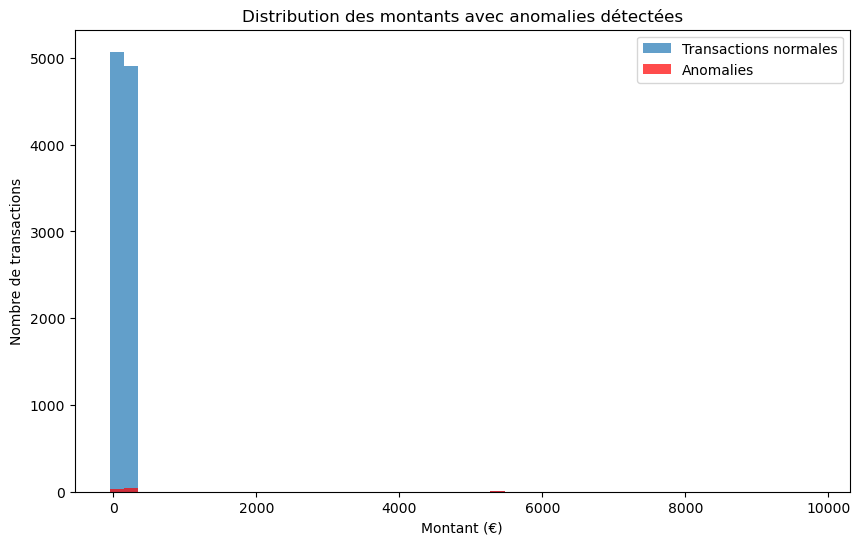

In [515]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['montant'], bins=50, alpha=0.7, label='Transactions normales')
plt.hist(df[df['anomalies'] == -1]['montant'], bins=50, alpha=0.7, label='Anomalies', color='red')
plt.xlabel('Montant (€)')
plt.ylabel('Nombre de transactions')
plt.title('Distribution des montants avec anomalies détectées')
plt.legend()
plt.show()


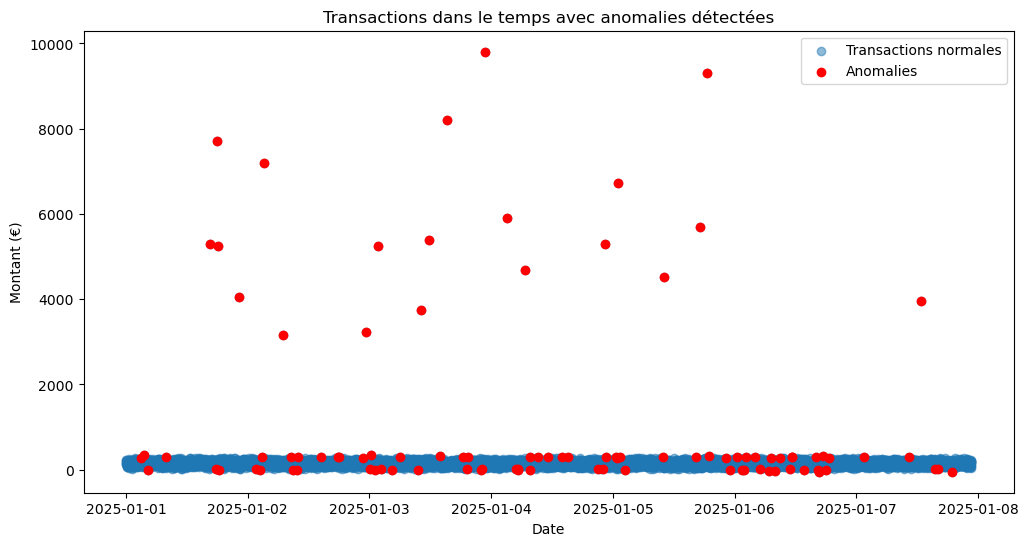

In [508]:
plt.figure(figsize=(12, 6))
plt.scatter(df['date'], df['montant'], label='Transactions normales', alpha=0.5)
plt.scatter(df[df['anomalies'] == -1]['date'], df[df['anomalies'] == -1]['montant'], color='red', label='Anomalies')
plt.xlabel('Date')
plt.ylabel('Montant (€)')
plt.title('Transactions dans le temps avec anomalies détectées')
plt.legend()
plt.show()

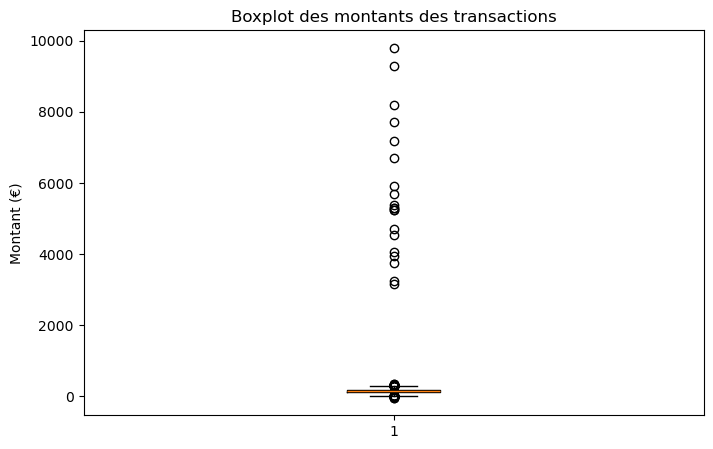

In [510]:
plt.figure(figsize=(8, 5))
plt.boxplot(df['montant'])
plt.title('Boxplot des montants des transactions')
plt.ylabel('Montant (€)')
plt.show()


### Conclusion et interprétation

Nous avons testé plusieurs modèles pour détecter les anomalies dans ce jeu de données avec différentes valeurs de paramètres. Parmi eux, l'algorithme Isolation Forest m’a semblé être le choix le plus adapté. Cependant, ce choix reste basé sur une évaluation personnelle et ne repose pas sur une expertise approfondie du domaine.

Il est important de souligner que les modèles de machine learning, bien qu’efficaces, ne sont que des outils d’aide à la décision. La véritable valeur d'une analyse pertinente réside dans la compréhension métier et l'expérience avec ce type de transactions financières, ainsi que dans la connaissance des anomalies couramment rencontrées. Sans cette expertise, les résultats obtenus peuvent être sujets à une marge d'erreur significative.

Pour améliorer la fiabilité des analyses, une collaboration étroite avec des experts du domaine et une meilleure connaissance des processus métiers seraient indispensables.

### Améliorations et optimisations

Pour améliorer la détection des anomalies, plusieurs optimisations pourraient être envisagées :

    Affinage des paramètres : Tester systématiquement différentes valeurs pour les hyperparamètres et utiliser des méthodes de validation croisée pour choisir les paramètres les plus adaptés.
    
    Exploration d’autres variables : Si davantage de données étaient disponibles, intégrer ces variables pourrait enrichir l’analyse et améliorer la détection des anomalies.
    
    Utilisation de méthodes hybrides : Combiner plusieurs algorithmes de détection d’anomalies pour obtenir des résultats plus robustes et réduire les faux positifs.
    
    Analyse temporelle approfondie : Extraire des caractéristiques temporelles pour détecter des comportements inhabituels selon le temps.

### Gestion d’un jeu de données plus grand ou plus complexe

Pour traiter un jeu de données beaucoup plus volumineux ou complexe, les approches suivantes seraient recommandées :

    Optimisation des ressources : Utiliser des techniques de traitement par lots ou des bibliothèques optimisées pour le calcul distribué comme PySpark.
    
    Réduction de la dimensionnalité : Employer des méthodes comme PCA pour réduire la complexité tout en conservant l’essentiel de l’information.
    
    Échantillonnage intelligent : Travailler sur des sous-échantillons représentatifs pour accélérer les calculs tout en préservant la qualité des résultats.
    
    Utilisation de solutions cloud : Exploiter des plateformes cloud pour bénéficier de ressources informatiques évolutives et gérer plus efficacement les volumes massifs de données.